In [1]:
# Load the regular expression library
import re
import sys
!{sys.executable} -m pip install inline
!{sys.executable} -m pip install matplotlib
import inline
import matplotlib
import pandas as pd

data = pd.read_csv('may_07_tweets.csv', low_memory=False)

# Filter to only English entries.
data = data[data['lang'] == 'en']

#remove columns other than the tweet, place, or user_location
data.drop(data.columns.difference(['text', 'place', 'user_location']), 1, inplace=True)

#filter out rows that
data1 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('california', flags=re.IGNORECASE, regex=True)).all(axis=1)]
data2 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('CA')).all(axis=1)]
data = [data1, data2]
result = pd.concat(data)
result.head()
#print(result)

,place,text,user_location
247,NaN,REOPENING KERN: The Bakersfield City Council ...,"Bakersfield, California"
509,NaN,Democrats’ hold on House seat in jeopardy as c...,NaN
1061,NaN,Democrats’ hold on House seat in jeopardy as c...,NaN
1182,NaN,California Coronavirus Update: Governor Gavin ...,California
1823,NaN,Advisers to California Gov. Gavin Newsom agree...,"Santa Maria, California"


In [2]:
import os
os.chdir('..')

# Remove punctuation
result['tweet_text_processed'] = result['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
result['tweet_text_processed'] = result['tweet_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
result['tweet_text_processed'].head()


247     reopening kern:  the bakersfield city council ...
509     democrats’ hold on house seat in jeopardy as c...
1061    democrats’ hold on house seat in jeopardy as c...
1182    california coronavirus update: governor gavin ...
1823    advisers to california gov gavin newsom agreed...
Name: tweet_text_processed, dtype: object

In [5]:
!{sys.executable} -m pip install wordcloud

  Using cached wordcloud-1.8.0-cp38-cp38-macosx_10_6_x86_64.whl (162 kB)


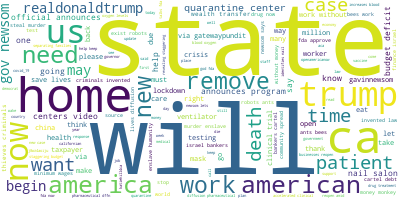

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(result['tweet_text_processed'].values))

#add stopwords from twitter and take out covid stuff we know the tweets are about covid
stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "california", "pandemic", "people"] + list(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

/Users/marcosgonzalez/Desktop/anaconda3/envs/new-r/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


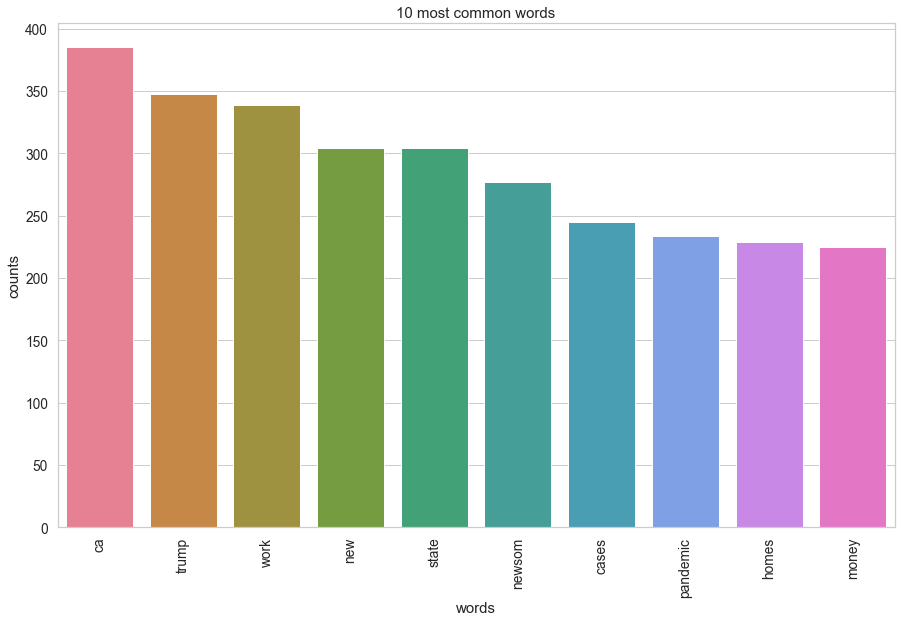

In [5]:
# Load the library with the CountVectorizer method
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install seaborn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import numpy as np

#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words and same ones from wordcloud
my_additional_stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "covidー19", "california", "people"]
count_vectorizer = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(result["tweet_text_processed"])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
drug fda help patients save lives god blood clinical treatment

Topic #1:
homes quarantine remove begins program official video centers announces gatewaypundit

Topic #2:
work money cases new deaths law taxpayers eat debt criminals

Topic #3:
trump ca realdonaldtrump americans state america ppe health need pandemic

Topic #4:
newsom gov budget deficit spread says nail businesses reopen community


In [8]:
%%time

!{sys.executable} -m pip install pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

CPU times: user 1.91 s, sys: 183 ms, total: 2.09 s
Wall time: 6.85 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.035758  0.004233       1        1  27.736478
2      0.167820  0.020159       2        1  20.015064
0     -0.110556  0.114508       3        1  18.535609
4     -0.059762 -0.170003       4        1  17.157171
1     -0.033259  0.031103       5        1  16.555679, topic_info=             Term        Freq       Total Category  logprob  loglift
16718        work  271.000000  271.000000  Default  30.0000  30.0000
10714      newsom  215.000000  215.000000  Default  29.0000  29.0000
7034          gov  150.000000  150.000000  Default  28.0000  28.0000
7632        homes  175.000000  175.000000  Default  27.0000  27.0000
12582  quarantine  149.000000  149.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3360        cases   28.806340  195.473532   Topic5  -5.9404  -0.1164
3037           ca   31.202825  309.960692   Topic5  -5.8605  -0.4975
16722     workers   22.254773   74.896293   Topic5  -6.1984   0.5849
15299       today   20.968784   68.562124   Topic5  -6.2580   0.6137
10656        need   20.183434  115.756410   Topic5  -6.2961   0.0518

[289 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1          2  0.985630        0001
12         2  0.969629          02
651        2  0.964044          41
653        5  0.870778        4135
770        4  0.951873         543
...      ...       ...         ...
16722      5  0.293740     workers
16823      1  0.132917     wwg1wga
16823      3  0.099688     wwg1wga
16823      5  0.764271     wwg1wga
16937      4  0.968181  xqqr7wlfvq

[493 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])